In [1]:
## widen the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import os
import torch
import torchvision
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
from collections import OrderedDict

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device_count = torch.cuda.device_count()
for i in range(device_count):
    device_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {device_name}")

GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090


In [4]:
## load device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device : {DEVICE}")

## create dataset save location
PATH = "./mnist/"
if os.path.exists(PATH):
    print(f"The directory '{PATH}' already exists.")
else:
    os.mkdir(PATH)
    print(f"The directory '{PATH}' successfully created.")

Current Device : cuda
The directory './mnist/' already exists.


In [5]:
## hyperparameters
EPOCHS = 15
BATCH_SIZE = 100
LEARNING_RATE = 0.005
INPUT_SIZE = 28*28

In [6]:
## Data preparation
totensor = torchvision.transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root=PATH, train=True, download=True, transform=totensor)
testset = torchvision.datasets.MNIST(root=PATH, train=False, download=True, transform=totensor)

if device_count == 1:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                              shuffle=True, num_workers=device_count)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=device_count)

In [7]:
## show some samples
def plot_dataset(dataloader, grid_width, grid_height, figure_width, figure_height):
    images, labels = next(iter(dataloader))
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    for i in range(grid_height):
        for j in range(grid_width):
            img_idx = np.random.choice(np.arange(BATCH_SIZE), replace=False)
            image, label = images[img_idx], labels[img_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label.item(), color='black')
            ax[i][j].imshow(image.squeeze(), cmap='gray')
        plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()

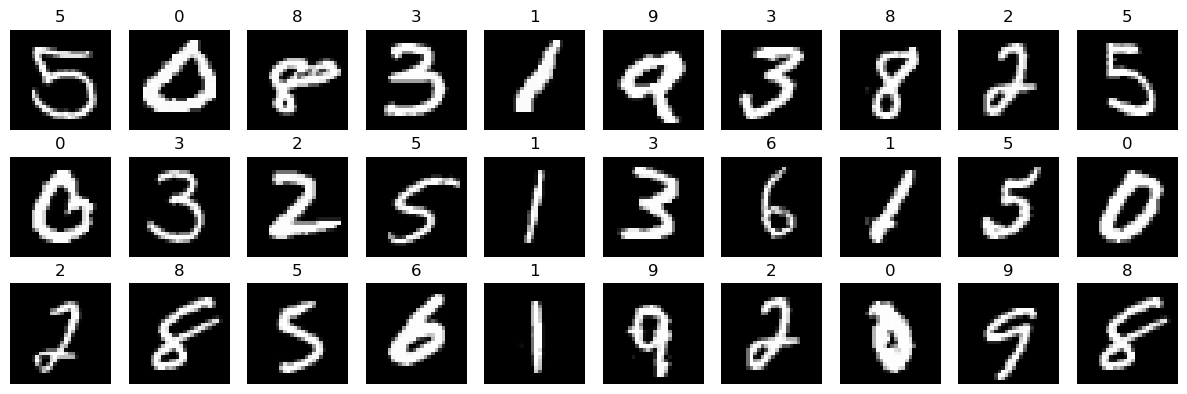

In [8]:
plot_dataset(trainloader, grid_width=10, grid_height=3, figure_width=12, figure_height=4)

# Naive AutoEncoder using 2 FC Layers

In [9]:
## Naive Autoencoder
class AutoEncoder(nn.Module):
    ## Two-FC-layer encoder and decoder
    def __init__(self, encoded_dim):
        super(AutoEncoder, self).__init__()
        
        self.input_size = 28 * 28
        self.hidden1 = 512
        self.hidden2 = encoded_dim
        
        self.fc1 = nn.Linear(self.input_size, self.hidden1)
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        
        self.fc3 = nn.Linear(self.hidden2, self.hidden1)
        self.fc4 = nn.Linear(self.hidden1, self.input_size)

    def encode(self, x):
        x = x.view(-1, self.input_size)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def decode(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

In [10]:
## loss functions and optimizer
LOSS_FUNCTIONS = ['BCE', 'MSE', 'MAE']
OPTIMIZERS = {
    'sgd': torch.optim.SGD, 
    'rmsprop': torch.optim.RMSprop, 
    'adagrad': torch.optim.Adagrad, 
    'adam': torch.optim.Adam, 
    'adamax': torch.optim.Adamax,
    'adadelta': torch.optim.Adadelta,
}

In [11]:
def train(epoch, model, loss_function, train_loader, optimizer, verbose=False):
    assert loss_function in LOSS_FUNCTIONS
    model.train()
    train_loss = 0
    batch_idx = 0
    for image, _ in train_loader:
        image = image.to(DEVICE)
        
        ## initialize the optimizer
        optimizer.zero_grad()
        
        ## decoded output
        decoded = model(image)
        
        ## compute loss for each batch
        if loss_function == "BCE":
            loss = F.binary_cross_entropy(decoded, image.view(-1, INPUT_SIZE))
        elif loss_function == "MSE":
            loss = F.mse_loss(decoded, image.view(-1, INPUT_SIZE))
        else:
            loss = F.l1_loss(decoded, image.view(-1, INPUT_SIZE))
        
        ## accumulate the total train loss during the epoch and backpropagation
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        ## Check training status
#         if batch_idx % 100 == 0:
#             print(f'Train Epoch: {epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t Loss: {loss.item()/len(image):.6f}')
        
        batch_idx += 1

    if verbose:
        print(f"Epoch: {epoch} Average training loss: {train_loss / len(train_loader.dataset):.6f}")
    
    return train_loss / len(train_loader.dataset)


def test(epoch, model, loss_function, test_loader, verbose=False):
    model.eval()
    test_loss = 0
    batch_idx = 0
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.to(DEVICE)
            decoded = model(image)

            ## compute loss for each batch
            if loss_function == "BCE":
                loss = F.binary_cross_entropy(decoded, image.view(-1, INPUT_SIZE))
            else:
                loss = F.mse_loss(decoded, image.view(-1, INPUT_SIZE))
            
            test_loss += loss.item()
        
        if verbose:
            print(f"Epoch: {epoch} Average test loss: {test_loss / len(test_loader.dataset):.6f}")
    
    return test_loss / len(test_loader.dataset)


In [12]:
def run(model, loss_fn, encoded_dim, optim_name, verbose1=False, verbose2=True, save_model=False):
    optimizer = OPTIMIZERS[optim_name](model.parameters(), lr=LEARNING_RATE)   
    train_losses = np.zeros(EPOCHS)
    test_losses = np.zeros(EPOCHS)
    for epoch in tqdm(range(EPOCHS)):
        train_loss = train(epoch, model, loss_fn, trainloader, optimizer, verbose=verbose1)
        test_loss = test(epoch, model, loss_fn, testloader, verbose=verbose1)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
    if verbose2:
        print(f"{loss_fn}\tEncoded dimension: {encoded_dim}\tAverage Training loss: {np.mean(train_losses):.6f}\tAverage Test loss: {np.mean(test_loss):.6f}")
        
    if save_model:
        saved_model = model.state_dict()
        fname = f"./saved_model_{loss_fn}_{encoded_dim}.pt"
        torch.save(saved_model, fname)
    return np.mean(train_losses), np.mean(test_losses)

In [13]:
# Loss function, Encoded dimension에 따른 loss 차이
encoded_dims = [16, 64, 144, 256]

bce_train_losses, bce_test_losses = dict(), dict()
for encoded_dim in encoded_dims:
    if device_count == 1:
        model = AutoEncoder(encoded_dim).to(DEVICE)
    else:
        device_ids = list(np.arange(device_count))
        model = nn.DataParallel(AutoEncoder(encoded_dim), device_ids=device_ids).to(DEVICE)

    print(model)
    train_loss, test_loss = run(model, "BCE", encoded_dim, "adam", verbose2=True, save_model=False)
    bce_train_losses[encoded_dim] = train_loss
    bce_test_losses[encoded_dim] = test_loss
    
mse_train_losses, mse_test_losses = dict(), dict()
for encoded_dim in encoded_dims:
    if device_count == 1:
        model = AutoEncoder(encoded_dim).to(DEVICE)
    else:
        device_ids = list(np.arange(device_count))
        model = nn.DataParallel(AutoEncoder(encoded_dim), device_ids=device_ids).to(DEVICE)

    print(model)
    train_loss, test_loss = run(model, "MSE", encoded_dim, "adam", verbose2=True, save_model=False)
    mse_train_losses[encoded_dim] = train_loss
    mse_test_losses[encoded_dim] = test_loss
    
mae_train_losses, mae_test_losses = dict(), dict()
for encoded_dim in encoded_dims:
    if device_count == 1:
        model = AutoEncoder(encoded_dim).to(DEVICE)
    else:
        device_ids = list(np.arange(device_count))
        model = nn.DataParallel(AutoEncoder(encoded_dim), device_ids=device_ids).to(DEVICE)

    print(model)
    train_loss, test_loss = run(model, "MAE", encoded_dim, "adam", verbose2=True, save_model=False)
    mae_train_losses[encoded_dim] = train_loss
    mae_test_losses[encoded_dim] = test_loss

DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

BCE	Encoded dimension: 16	Average Training loss: 0.001165	Average Test loss: 0.000989
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

BCE	Encoded dimension: 64	Average Training loss: 0.001023	Average Test loss: 0.000852
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=144, bias=True)
    (fc3): Linear(in_features=144, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

BCE	Encoded dimension: 144	Average Training loss: 0.000893	Average Test loss: 0.000738
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

BCE	Encoded dimension: 256	Average Training loss: 0.000855	Average Test loss: 0.000710
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MSE	Encoded dimension: 16	Average Training loss: 0.000176	Average Test loss: 0.000113
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MSE	Encoded dimension: 64	Average Training loss: 0.000108	Average Test loss: 0.000049
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=144, bias=True)
    (fc3): Linear(in_features=144, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MSE	Encoded dimension: 144	Average Training loss: 0.000089	Average Test loss: 0.000037
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MSE	Encoded dimension: 256	Average Training loss: 0.000077	Average Test loss: 0.000035
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MAE	Encoded dimension: 16	Average Training loss: 0.000664	Average Test loss: 0.000277
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MAE	Encoded dimension: 64	Average Training loss: 0.000542	Average Test loss: 0.000183
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=144, bias=True)
    (fc3): Linear(in_features=144, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MAE	Encoded dimension: 144	Average Training loss: 0.000485	Average Test loss: 0.000137
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MAE	Encoded dimension: 256	Average Training loss: 0.000502	Average Test loss: 0.000130


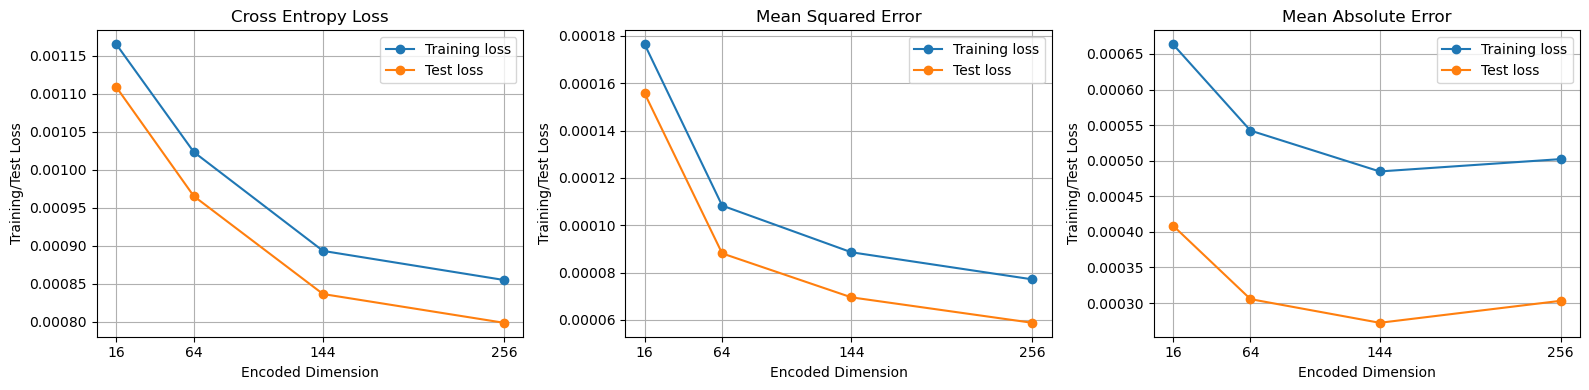

In [14]:
plt.figure(figsize=(16, 4))

plt.subplot(131)
plt.plot(encoded_dims, bce_train_losses.values(), label=f"Training loss", marker='o')
plt.plot(encoded_dims, bce_test_losses.values(), label=f"Test loss", marker='o')
plt.grid(True)
plt.legend()
plt.xlabel("Encoded Dimension")
plt.ylabel("Training/Test Loss")
plt.xticks(encoded_dims)
plt.title("Cross Entropy Loss")

plt.subplot(132)
plt.plot(encoded_dims, mse_train_losses.values(), label=f"Training loss", marker='o')
plt.plot(encoded_dims, mse_test_losses.values(), label=f"Test loss", marker='o')
plt.grid(True)
plt.legend()
plt.xlabel("Encoded Dimension")
plt.ylabel("Training/Test Loss")
plt.xticks(encoded_dims)
plt.title("Mean Squared Error")

plt.subplot(133)
plt.plot(encoded_dims, mae_train_losses.values(), label=f"Training loss", marker='o')
plt.plot(encoded_dims, mae_test_losses.values(), label=f"Test loss", marker='o')
plt.grid(True)
plt.legend()
plt.xlabel("Encoded Dimension")
plt.ylabel("Training/Test Loss")
plt.xticks(encoded_dims)
plt.title("Mean Absolute Error")

plt.tight_layout()
plt.show()

In [15]:
# Final training
encoded_dim = 12*12
for loss_fn in LOSS_FUNCTIONS:
    if device_count == 1:
        model = AutoEncoder(encoded_dim).to(DEVICE)
    else:
        device_ids = list(np.arange(device_count))
        model = nn.DataParallel(AutoEncoder(encoded_dim), device_ids=device_ids).to(DEVICE)

    print(model)
    train_loss, test_loss = run(model, loss_fn, encoded_dim, "adam", verbose2=True, save_model=True)

DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=144, bias=True)
    (fc3): Linear(in_features=144, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

BCE	Encoded dimension: 144	Average Training loss: 0.000910	Average Test loss: 0.000758
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=144, bias=True)
    (fc3): Linear(in_features=144, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MSE	Encoded dimension: 144	Average Training loss: 0.000084	Average Test loss: 0.000037
DataParallel(
  (module): AutoEncoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=144, bias=True)
    (fc3): Linear(in_features=144, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
  )
)


  0%|          | 0/15 [00:00<?, ?it/s]

MAE	Encoded dimension: 144	Average Training loss: 0.000476	Average Test loss: 0.000140


In [16]:
## Comparison between the ground truth and re-constructed image
def model_comparison(loss_fn, encoded_dim, indices, dataloader, grid_width, grid_height, figure_width, figure_height, view_encoded=False):
    images, labels = next(iter(dataloader))
    view_size = int(np.sqrt(encoded_dim))
    
    ## show ground truth
    print("Ground Truth")
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    for i in range(grid_height):
        for j in range(grid_width):
            img_idx = indices[i*grid_width + j]
            image, label = images[img_idx], labels[img_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label.item(), color='black')
            ax[i][j].imshow(image.squeeze(), cmap='gray')
        plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()
    
    ## load the trained model
    model = AutoEncoder(encoded_dim)
    checkpoint = torch.load(f'saved_model_{loss_fn}_{encoded_dim}.pt')
    state_dict = OrderedDict()
    for key, value in checkpoint.items():
        key = key.replace('module.', '')
        state_dict[key] = value
    model.load_state_dict(state_dict)
    model.eval()
    
    if view_encoded:
        ## show the encoded images
        print("Encoded")
        fig, ax = plt.subplots(grid_height, grid_width)
        fig.set_size_inches(figure_width, figure_height)
        for i in range(grid_height):
            for j in range(grid_width):
                img_idx = indices[i*grid_width + j]
                image, label = images[img_idx], labels[img_idx]
                encoded = model.encode(image).detach().numpy()

                ax[i][j].axis('off')
                ax[i][j].set_title(label.item(), color='black')
                ax[i][j].imshow(encoded.reshape(view_size, view_size), cmap='gray')
            plt.subplots_adjust(hspace=0.25)
        plt.tight_layout()
        plt.show()        
    
    
    ## show the re-constructed images
    print("Reconstructed")
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    for i in range(grid_height):
        for j in range(grid_width):
            img_idx = indices[i*grid_width + j]
            image, label = images[img_idx], labels[img_idx]
            decoded = model(image).detach().numpy()

            ax[i][j].axis('off')
            ax[i][j].set_title(label.item(), color='black')
            ax[i][j].imshow(decoded.reshape(28, 28), cmap='gray')
        plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()

BCE
Ground Truth


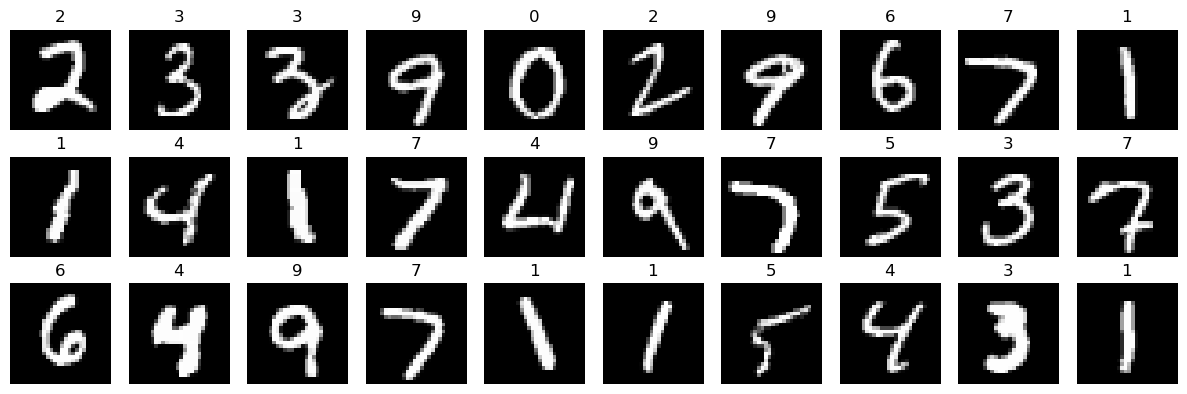

Encoded


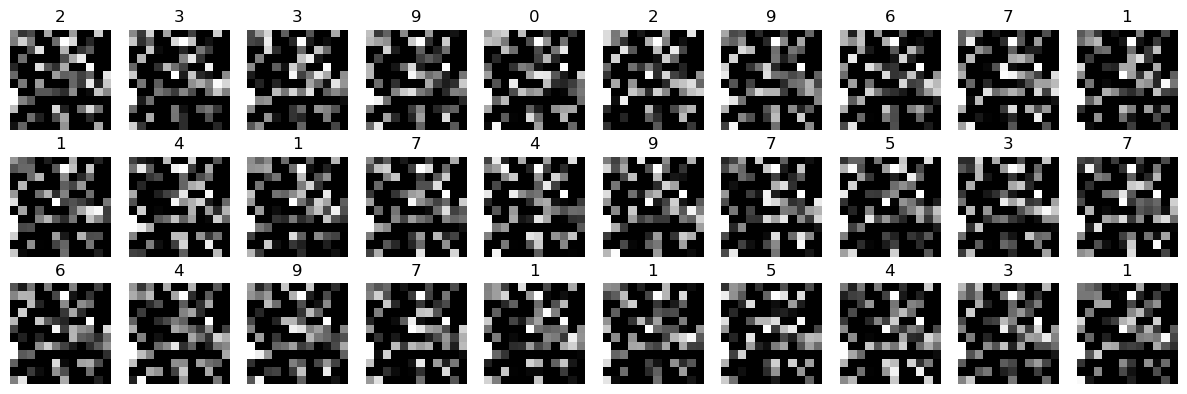

Reconstructed


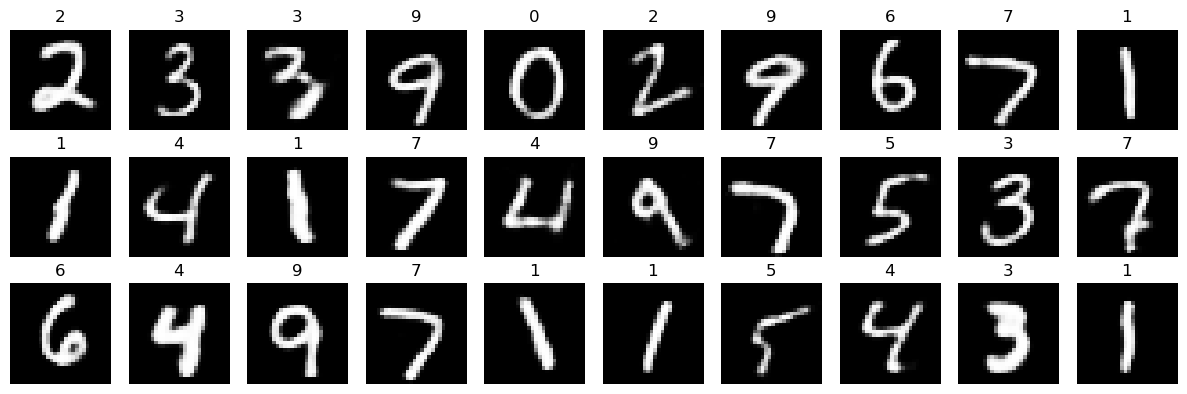

MSE
Ground Truth


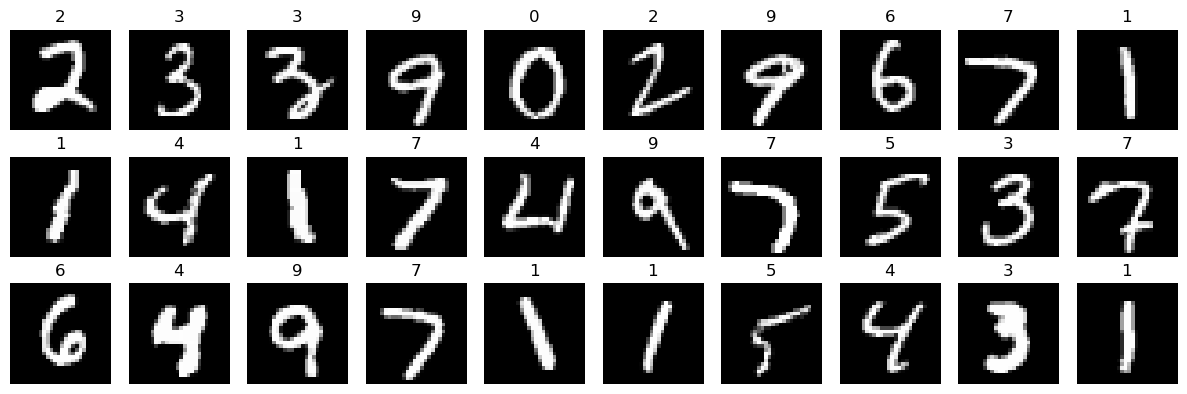

Encoded


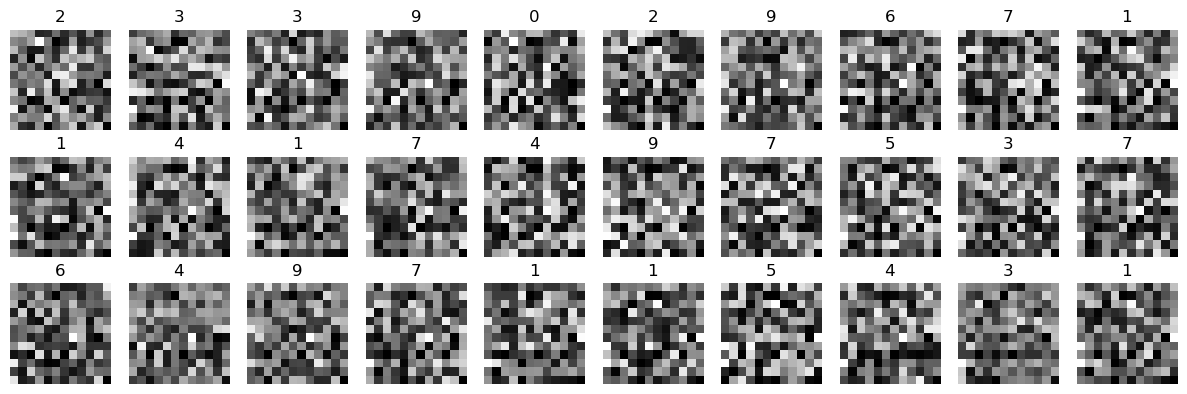

Reconstructed


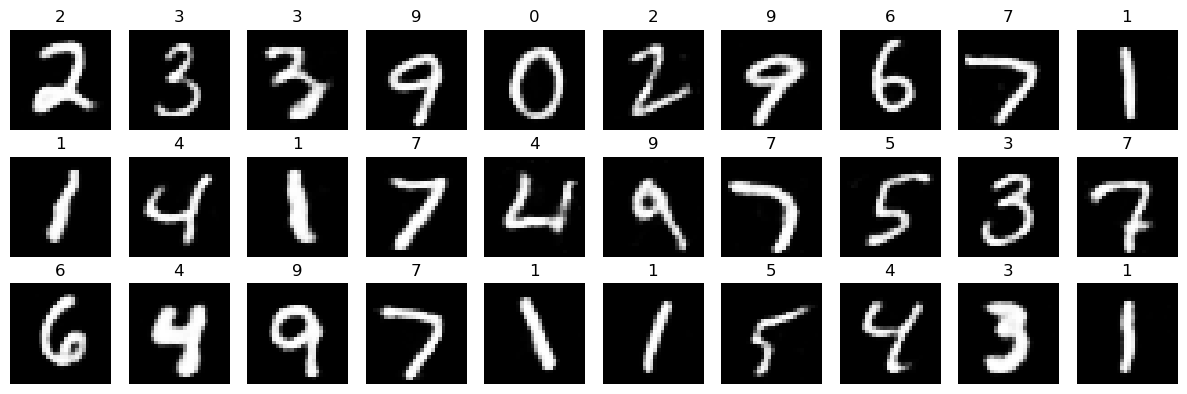

MAE
Ground Truth


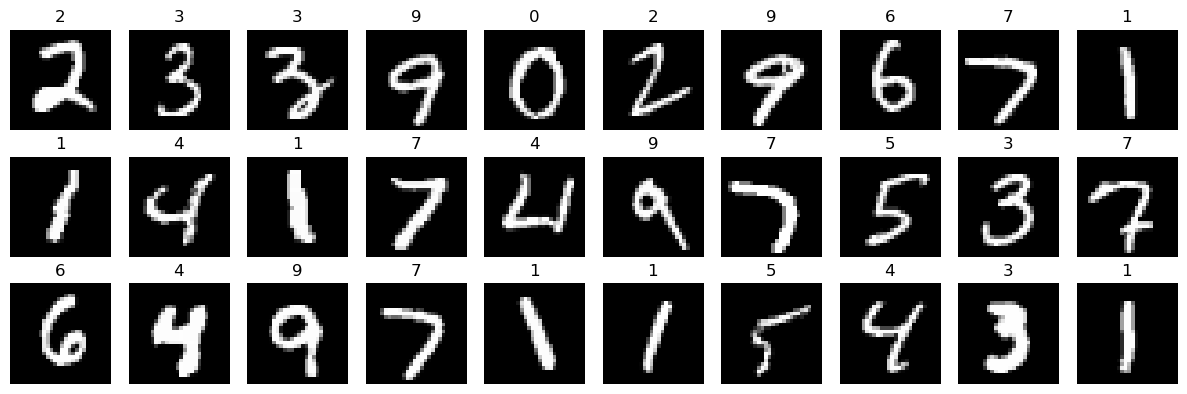

Encoded


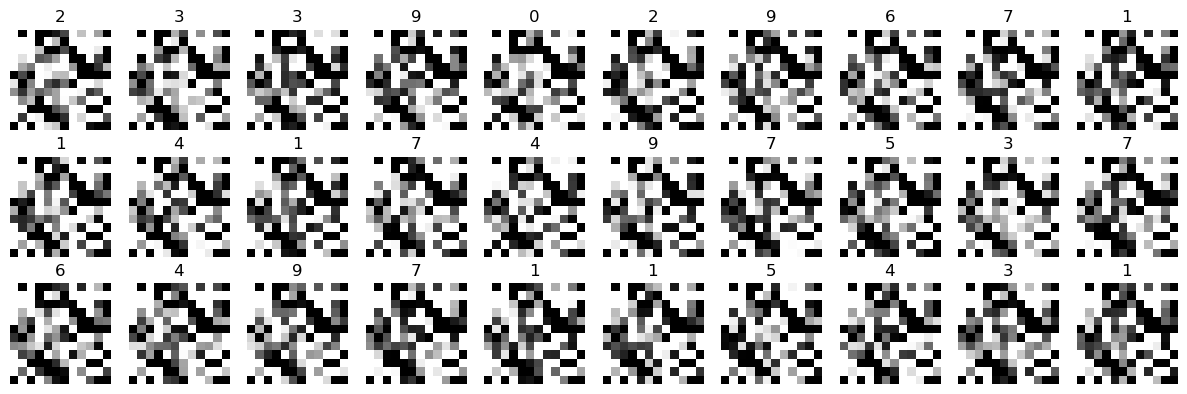

Reconstructed


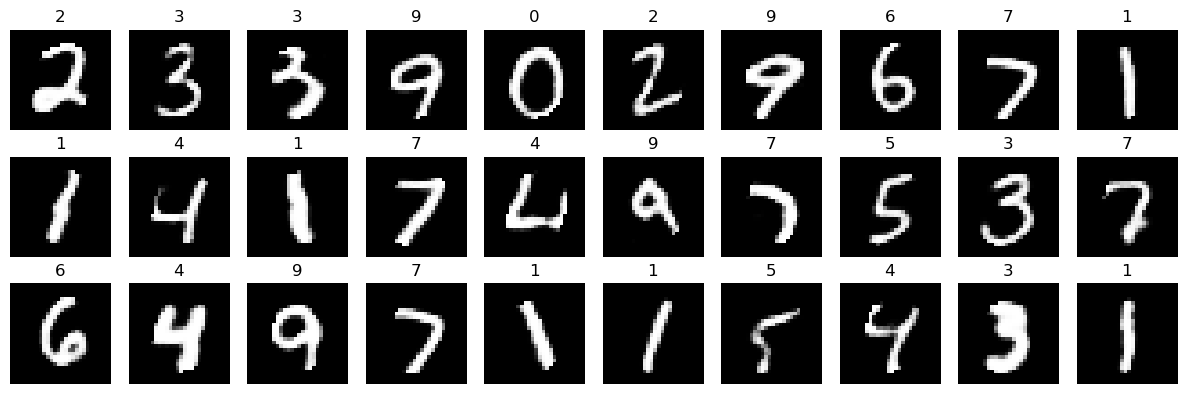

In [17]:
grid_width, grid_height = 10, 3
figure_width, figure_height = 12, 4
indices = np.random.choice(np.arange(BATCH_SIZE), replace=False, size=grid_height*grid_width)
sampleloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, 
                                           shuffle=False, num_workers=device_count)

for loss_fn in LOSS_FUNCTIONS:
    print(loss_fn)
    model_comparison(loss_fn, 12*12, indices, sampleloader, grid_width, grid_height, figure_width, figure_height, view_encoded=True)

# AutoEncoder using simple CNN

In [ ]:
## Naive Autoencoder
class CNNAE(nn.Module):
    ## Three-CNN-layer encoder and decoder
    def __init__(self):
        super(CNNAE, self).__init__()
        
        self.input_size = 28 * 28
        self.hidden1 = 256
        self.hidden2 = 256
        self.hidden3 = 144
        
        ## Encoder layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.hidden1, kernel_size=3, padding='same'),
            nn.Sigmoid()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=self.hidden1, out_channels=self.hidden2, kernel_size=3, padding='same'),
            nn.Sigmoid()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=self.hidden2, out_channels=self.hidden3, kernel_size=3, padding='same'),
            nn.Sigmoid()
        )
        
        self.encoder_out = 28
        
        ## Decoder Layer
        self.fc1 = nn.Sequential(
            nn.Linear(self.encoder_out, self.hidden2),
            nn.Sigmoid()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(self.hidden2, self.hidden1),
            nn.Sigmoid()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(self.hidden1, self.input_size),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x
    
    def decode(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    def forward(self, x):
        encoded = self.encode(x)
#         print(encoded.size())
        decoded = self.decode(encoded)
        return decoded

In [ ]:
def train(epoch, model, loss_function, train_loader, optimizer, verbose=False):
    assert loss_function in LOSS_FUNCTIONS
    model.train()
    train_loss = 0
    batch_idx = 0
    for image, _ in train_loader:
        image = image.to(DEVICE)
        
        ## initialize the optimizer
        optimizer.zero_grad()
        
        ## decoded output
        decoded = model(image)
        
        ## compute loss for each batch
        if loss_function == "BCE":
            criterion = nn.CrossEntropyLoss()
        elif loss_function == "MSE":
            criterion = nn.MSELoss()
        else:
            criterion = F.L1Loss()
        
        loss = criterion(decoded, image.squeeze())
        ## accumulate the total train loss during the epoch and backpropagation
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        ## Check training status
#         if batch_idx % 100 == 0:
#             print(f'Train Epoch: {epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t Loss: {loss.item()/len(image):.6f}')
        
        batch_idx += 1

    if verbose:
        print(f"Epoch: {epoch} Average training loss: {train_loss / len(train_loader.dataset):.6f}")
    
    return train_loss / len(train_loader.dataset)


def test(epoch, model, loss_function, test_loader, verbose=False):
    model.eval()
    test_loss = 0
    batch_idx = 0
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.to(DEVICE)
            decoded = model(image)

            ## compute loss for each batch
            if loss_function == "BCE":
                criterion = nn.CrossEntropyLoss()
            elif loss_function == "MSE":
                criterion = nn.MSELoss()
            else:
                criterion = F.L1Loss()

            loss = criterion(decoded, image.squeeze())
            
            test_loss += loss.item()
        
        if verbose:
            print(f"Epoch: {epoch} Average test loss: {test_loss / len(test_loader.dataset):.6f}")
    
    return test_loss / len(test_loader.dataset)



def run(model, loss_fn, optim_name, verbose1=False, verbose2=True, save_model=False):
    optimizer = OPTIMIZERS[optim_name](model.parameters(), lr=LEARNING_RATE)   
    train_losses = np.zeros(EPOCHS)
    test_losses = np.zeros(EPOCHS)
    for epoch in tqdm(range(EPOCHS)):
        train_loss = train(epoch, model, loss_fn, trainloader, optimizer, verbose=verbose1)
        test_loss = test(epoch, model, loss_fn, testloader, verbose=verbose1)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
    if verbose2:
        print(f"{loss_fn}\tAverage Training loss: {np.mean(train_losses):.6f}\tAverage Test loss: {np.mean(test_loss):.6f}")
        
    if save_model:
        saved_model = model.state_dict()
        fname = f"./saved_model_{loss_fn}_{model.__class__.__name__}.pt"
        torch.save(saved_model, fname)
    return np.mean(train_losses), np.mean(test_losses)

In [ ]:
for loss_fn in LOSS_FUNCTIONS:
    if device_count == 1:
        model = CNNAE().to(DEVICE)
    else:
        device_ids = list(np.arange(device_count))
        model = nn.DataParallel(CNNAE(), device_ids=device_ids).to(DEVICE)

    print(model)
    train_loss, test_loss = run(model, loss_fn, "adam", verbose2=True, save_model=True)